# In this classwork we will a) show how to load image data with Pytorch. Then we will b) build and train a feed forward and a convolutional neural network to classify images as Cat Vs No-Cat, c) learn how to use a validation set to evaluate the performance during training d) use regularization techniques to suppress overfitting e) save a trained model to infer on a testin dataset

Make the necessary imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import h5py

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms

# a)

Load the data from an hdf5 file

In [2]:
train_file = h5py.File('/afs/desy.de/user/i/itsaklid/datasets/train_catvnoncat.h5', 'r')
test_file = h5py.File('/afs/desy.de/user/i/itsaklid/datasets/test_catvnoncat.h5', 'r')


Inspect how imbalanced the dataset is in terms of labels

In [3]:
u, c = np.unique(train_file['train_set_y'][:]==1, return_counts=True)
print(u,c)
u, c = np.unique(test_file['test_set_y'][:]==1, return_counts=True)
print(u,c)

[False  True] [137  72]
[False  True] [17 33]


In Pytorch we typically need a Dataset that is fed into a Dataloader. Then we iterate over the Dataloader object 

In [4]:
class dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int64)

    def __getitem__(self, idx):
        return self.x[idx].permute(2, 0, 1), self.y[idx]
    def __len__(self):
        length = self.x.shape[0]
        return length

In [5]:
train_set = dataset(train_file['train_set_x'][:], train_file['train_set_y'][:])

In [6]:
train_loader = torch.utils.data.DataLoader(
            train_set,
            batch_size=8,
            shuffle=True,
            drop_last = True,
        ) 

Let's now inspect the dataloader

Iterating the dataloader
Gives us a list of length 26
Which is the number of batches of data
By taking one batch, we get a list of: 2
with two tensors: 0th torch.Size([8, 3, 64, 64]) 1st torch.Size([8])


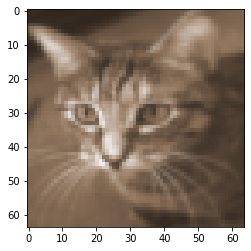

With label: tensor(1)


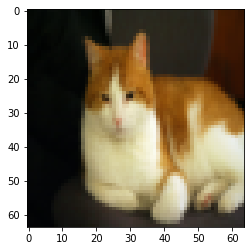

With label: tensor(1)


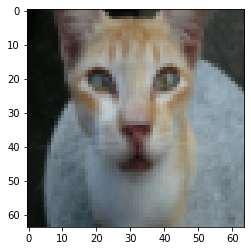

With label: tensor(1)


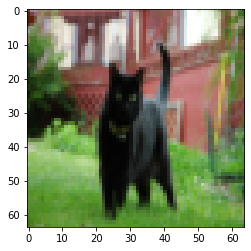

With label: tensor(1)


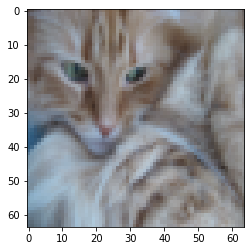

With label: tensor(1)


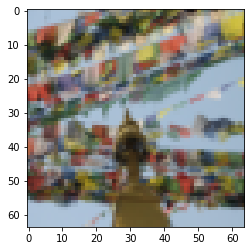

With label: tensor(0)


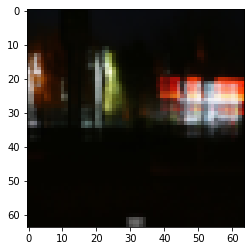

With label: tensor(0)


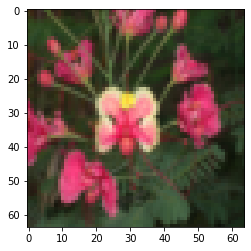

With label: tensor(0)


In [7]:
print('Iterating the dataloader')
e = iter(train_loader)
print('Gives us a list of length', len(e))
print('Which is the number of batches of data')
e.next()
samples = e.next()
print('By taking one batch, we get a list of:', len(samples))
print('with two tensors: 0th', samples[0].shape, '1st', samples[1].shape)
cats = samples[1][:] == 1
#plt.imshow(samples[0][5])
idx_cats = np.where(cats==True)
idx_nocat = np.where(cats==False)
for c in idx_cats[0]:
    plt.imshow(samples[0][c].to(dtype=torch.uint8).permute(1, 2, 0))
    plt.show()
    print('With label:', samples[1][c])
for d in idx_nocat[0]:
    plt.imshow(samples[0][d].to(dtype=torch.uint8).permute(1, 2, 0))
    plt.show()
    print('With label:', samples[1][d])

# b)

Let's first build a simple Feed Forward Neural Network 

In [8]:
class SimpleFeedForward(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleFeedForward, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)        
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, num_classes)
        
        
    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        #x = self.l2(x)
        #x = F.relu(x)        
        out = self.l3(x)
        
        return out

In [9]:
npixels = 64
input_size = (npixels)**2 
hidden = 256
num_classes =2
epochs = 20
lr = 10e-3

# If you want to use a GPU 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [10]:
model = SimpleFeedForward(input_size, hidden, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
#steps = len(train_loader)

ff_loss_history = []
ff_acc_history = []

for epoch in range(epochs):
    
    total_loss = 0
    
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        
        #For accuracy
        n_correct = 0
        n_samples = 0 
        
        images = images.to(device) #(B, C, H, W)  
        labels = labels.to(device)
        
        #convert images grey for FF network
        images = torch.mean(images, dim=1) # (B, H, W)
        images = images.reshape(-1, input_size) #(B, H*W)
        
        # here you predict
        y_pred = model(images)
        loss = criterion(y_pred, 
                         labels)
        total_loss += loss
        
        _, predictions = torch.max(y_pred, 1)
            
        #For accuracy
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
        
        # Zeros the gradients
        optimizer.zero_grad()
        # Calculate the gradients
        loss.backward()
        #Update the weights
        optimizer.step()
        
    acc = 100.0 * n_correct / n_samples    
    ff_loss_history.append(total_loss/i)
    ff_acc_history.append(acc)
    print(f'epoch:{epoch:.0f}|loss:{ff_loss_history[-1]:.2f}|accuracy = {acc:.2f}')
    
    

   

epoch:0|loss:1031.57|accuracy = 62.50
epoch:1|loss:150.22|accuracy = 62.50
epoch:2|loss:1.41|accuracy = 75.00
epoch:3|loss:0.70|accuracy = 50.00
epoch:4|loss:0.68|accuracy = 25.00
epoch:5|loss:0.67|accuracy = 50.00
epoch:6|loss:0.67|accuracy = 75.00
epoch:7|loss:0.67|accuracy = 50.00
epoch:8|loss:0.67|accuracy = 37.50
epoch:9|loss:0.67|accuracy = 62.50
epoch:10|loss:0.67|accuracy = 62.50
epoch:11|loss:0.67|accuracy = 50.00
epoch:12|loss:0.67|accuracy = 37.50
epoch:13|loss:0.67|accuracy = 75.00
epoch:14|loss:0.67|accuracy = 75.00
epoch:15|loss:0.67|accuracy = 62.50
epoch:16|loss:0.67|accuracy = 62.50
epoch:17|loss:0.67|accuracy = 62.50
epoch:18|loss:0.67|accuracy = 87.50
epoch:19|loss:0.67|accuracy = 75.00


# Now let's build a Convolutional Network

In [12]:
class SimpleConv(nn.Module):
    def __init__(self):
        super(SimpleConv, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 2)        
        self.conv2 = nn.Conv2d(8, 16, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*15*15, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x))) # (B, C , H, W)
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x))) # (B, C , H, W)
        #print(x.shape)
        x = x.view(-1, 16*15*15) # (B, C*H*W)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = self.fc3(x)
        #print(x.shape)
        
        return x
        
    
        
    

In [13]:
model = SimpleConv().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [14]:

epochs = 20

conv_loss_history = []
conv_acc_history = []

for epoch in range(epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        n_correct = 0
        n_samples = 0 
        
        images = images.to(device) #(B, C, H, W)
        labels = labels.to(device)
        
        y_pred = model(images)
        loss = criterion(y_pred, labels)
        
        _, predictions = torch.max(y_pred, 1)
            
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    acc = 100.0 * n_correct / n_samples    
    conv_loss_history.append(loss)
    conv_acc_history.append(acc)
    print(f'epoch:{epoch:.0f}|loss:{loss.item():.2f}|accuracy = {acc:.2f}')
        

epoch:0|loss:0.50|accuracy = 87.50
epoch:1|loss:0.79|accuracy = 37.50
epoch:2|loss:0.66|accuracy = 62.50
epoch:3|loss:0.66|accuracy = 62.50
epoch:4|loss:0.56|accuracy = 75.00
epoch:5|loss:0.57|accuracy = 62.50
epoch:6|loss:0.39|accuracy = 62.50
epoch:7|loss:0.61|accuracy = 62.50
epoch:8|loss:0.60|accuracy = 75.00
epoch:9|loss:0.66|accuracy = 62.50
epoch:10|loss:0.58|accuracy = 75.00
epoch:11|loss:0.61|accuracy = 75.00
epoch:12|loss:1.14|accuracy = 50.00
epoch:13|loss:0.66|accuracy = 62.50
epoch:14|loss:0.75|accuracy = 50.00
epoch:15|loss:0.91|accuracy = 25.00
epoch:16|loss:0.66|accuracy = 62.50
epoch:17|loss:0.66|accuracy = 62.50
epoch:18|loss:0.66|accuracy = 62.50
epoch:19|loss:0.55|accuracy = 87.50


Now let's plot the results for both  the Feed forward and the Convolutional network

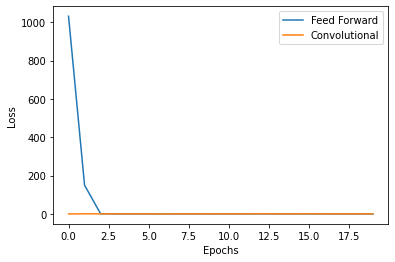

In [15]:
plt.plot(np.arange(epochs), ff_loss_history, label='Feed Forward')
plt.plot(np.arange(epochs), conv_loss_history, label='Convolutional')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

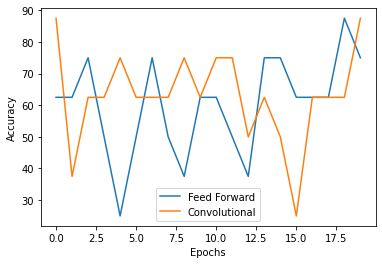

In [16]:
plt.plot(np.arange(epochs), ff_acc_history, label='Feed Forward')
plt.plot(np.arange(epochs), conv_acc_history, label='Convolutional')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Now let's do the same for the Fashion-MNIST dataset. The Cat no-Cat datasets is an easy one to classify but quite small for the results to be trusted.

In [17]:
#Load or download the FashionMNIST dataset

train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()])) 

In [18]:
train_loader = torch.utils.data.DataLoader(
            train_set,
            batch_size=128,
            shuffle=True,
            drop_last = True,
        ) 

Let's inpect the dataloader again

Iterating the dataloader
Gives us a list of length 468
Which is the number of batches of data
By taking one batch, we get a list of: 2
with two tensors: 0th torch.Size([128, 1, 28, 28]) 1st torch.Size([128])


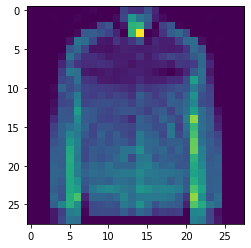

With label: tensor(4)


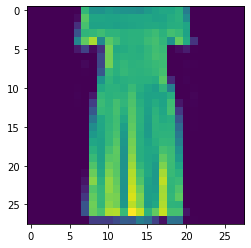

With label: tensor(3)


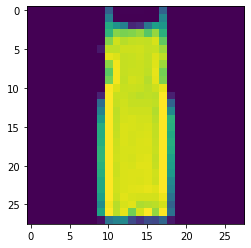

With label: tensor(3)


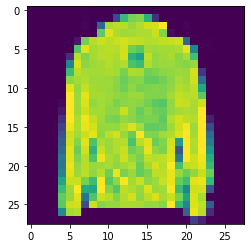

With label: tensor(4)


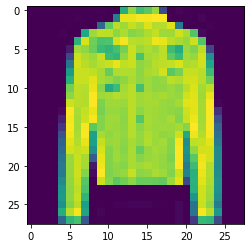

With label: tensor(4)


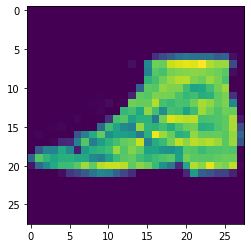

With label: tensor(9)


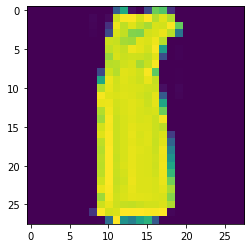

With label: tensor(3)


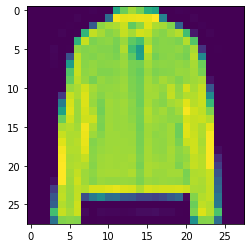

With label: tensor(4)


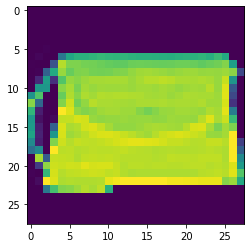

With label: tensor(8)


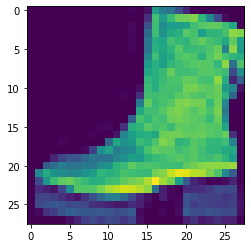

With label: tensor(9)


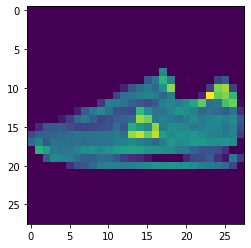

With label: tensor(7)


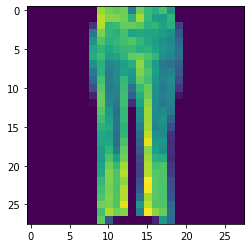

With label: tensor(1)


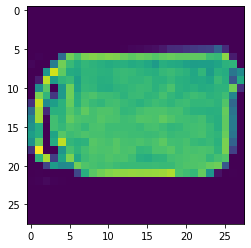

With label: tensor(8)


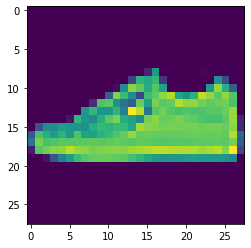

With label: tensor(7)


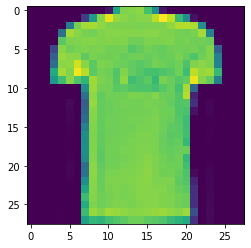

With label: tensor(0)


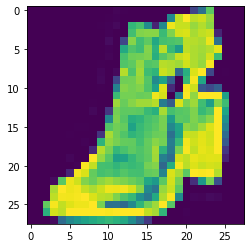

With label: tensor(5)


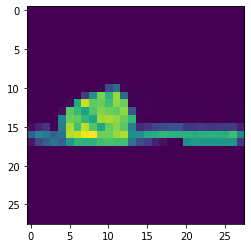

With label: tensor(5)


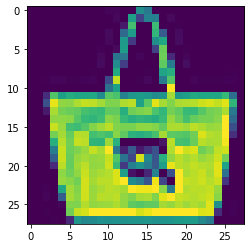

With label: tensor(8)


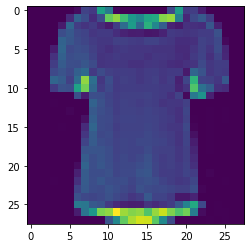

With label: tensor(6)


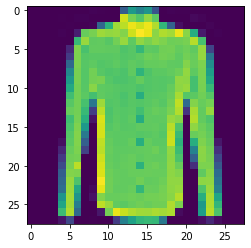

With label: tensor(6)


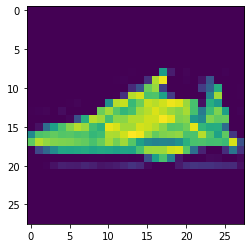

With label: tensor(7)


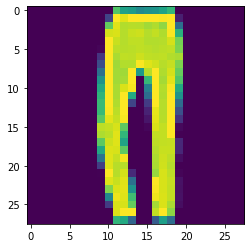

With label: tensor(1)


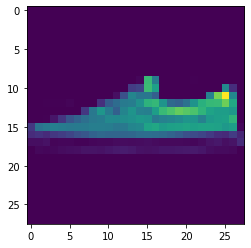

With label: tensor(7)


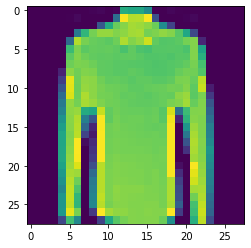

With label: tensor(6)


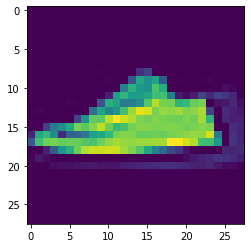

With label: tensor(7)


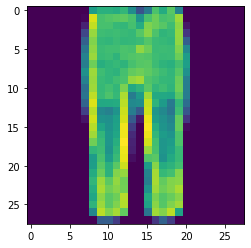

With label: tensor(1)


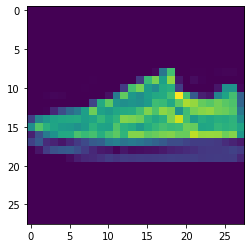

With label: tensor(7)


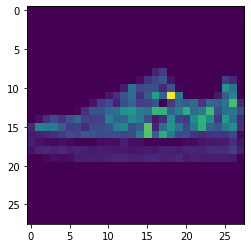

With label: tensor(7)


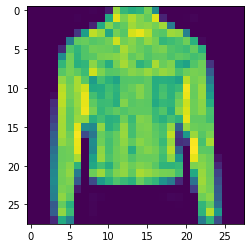

With label: tensor(4)


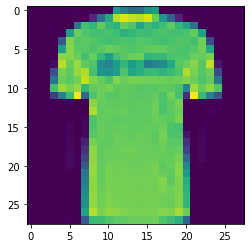

With label: tensor(0)


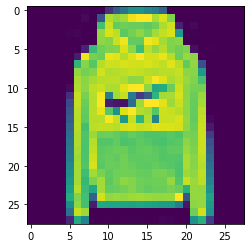

With label: tensor(2)


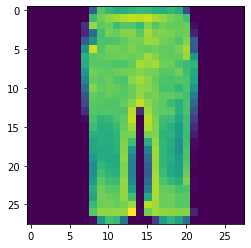

With label: tensor(1)


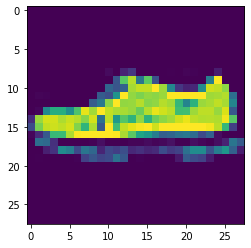

With label: tensor(5)


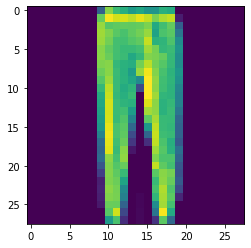

With label: tensor(1)


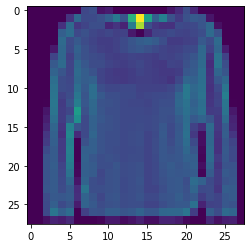

With label: tensor(2)


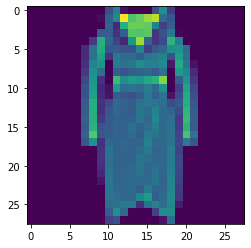

With label: tensor(3)


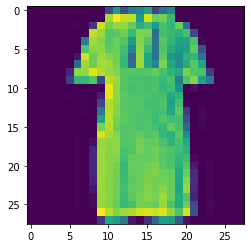

With label: tensor(3)


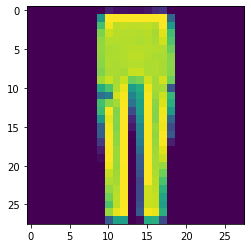

With label: tensor(1)


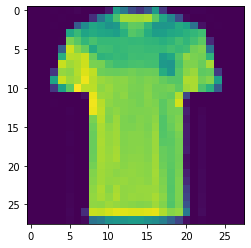

With label: tensor(0)


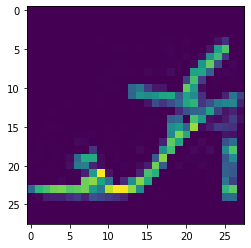

With label: tensor(5)


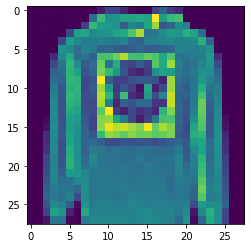

With label: tensor(2)


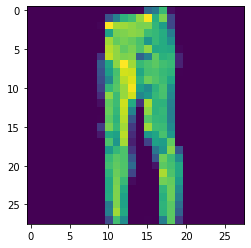

With label: tensor(1)


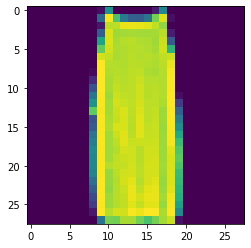

With label: tensor(3)


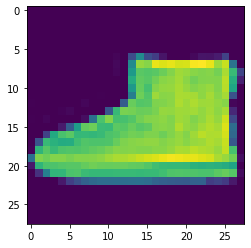

With label: tensor(9)


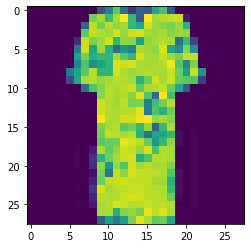

With label: tensor(3)


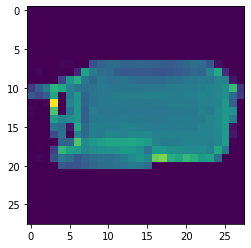

With label: tensor(8)


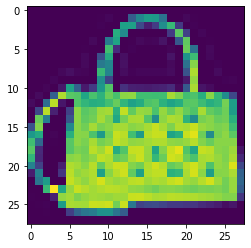

With label: tensor(8)


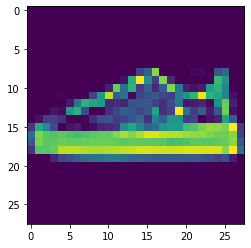

With label: tensor(7)


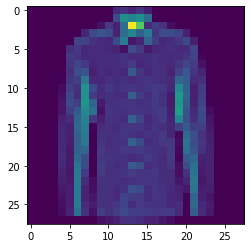

With label: tensor(6)


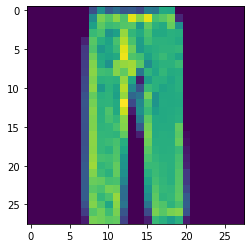

With label: tensor(1)


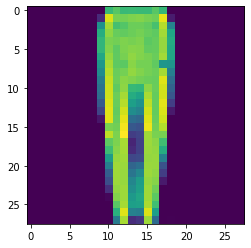

With label: tensor(1)


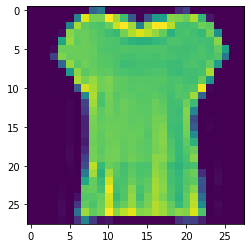

With label: tensor(0)


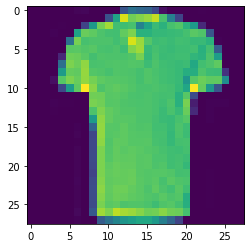

With label: tensor(0)


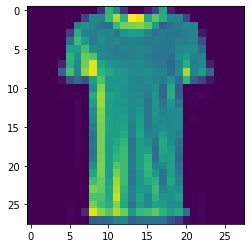

With label: tensor(0)


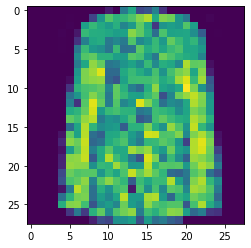

With label: tensor(4)


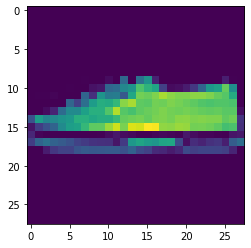

With label: tensor(7)


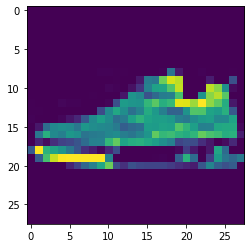

With label: tensor(7)


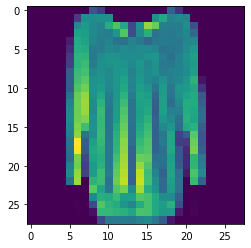

With label: tensor(2)


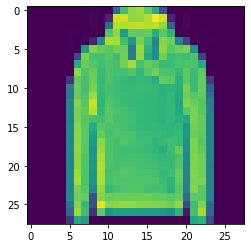

With label: tensor(2)


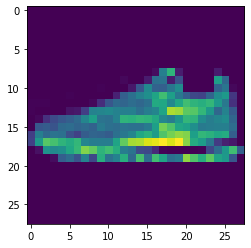

With label: tensor(7)


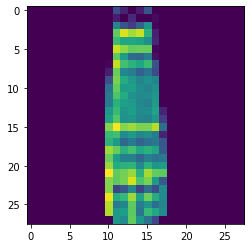

With label: tensor(3)


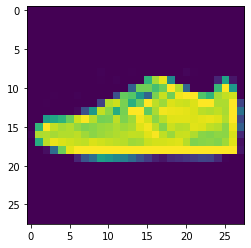

With label: tensor(7)


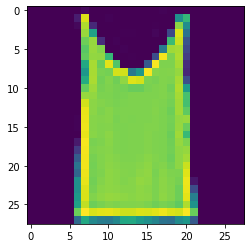

With label: tensor(6)


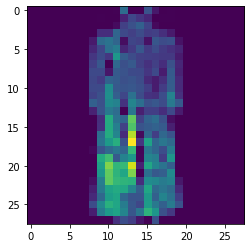

With label: tensor(3)


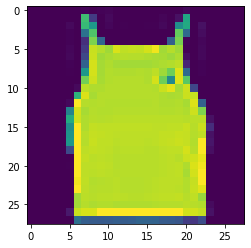

With label: tensor(0)


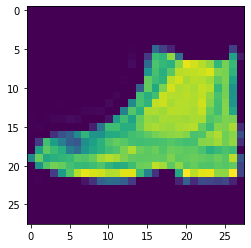

With label: tensor(9)


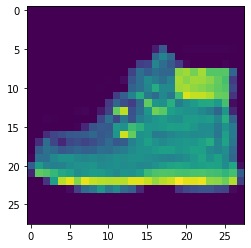

With label: tensor(9)


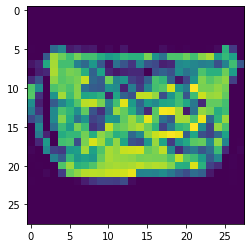

With label: tensor(8)


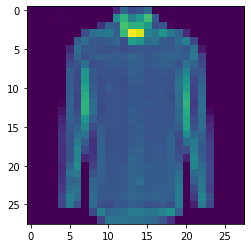

With label: tensor(6)


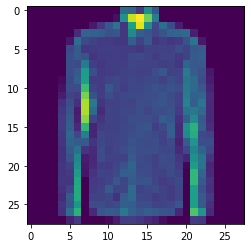

With label: tensor(6)


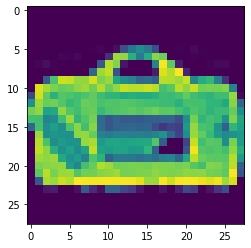

With label: tensor(8)


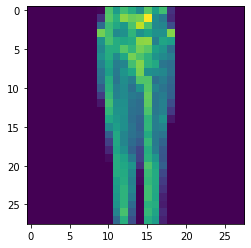

With label: tensor(1)


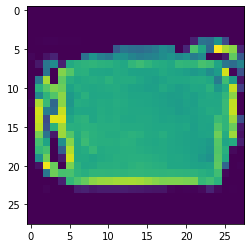

With label: tensor(8)


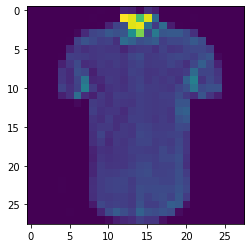

With label: tensor(6)


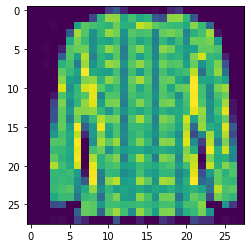

With label: tensor(0)


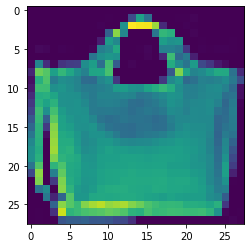

With label: tensor(8)


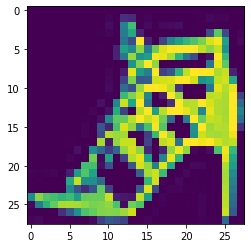

With label: tensor(5)


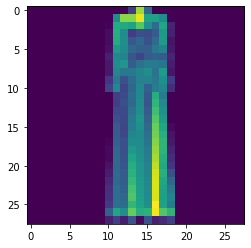

With label: tensor(3)


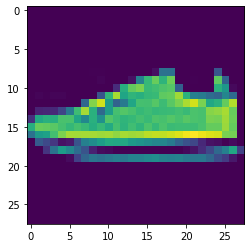

With label: tensor(7)


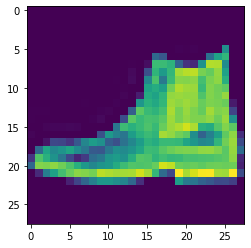

With label: tensor(9)


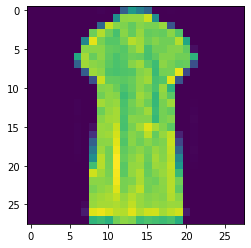

With label: tensor(3)


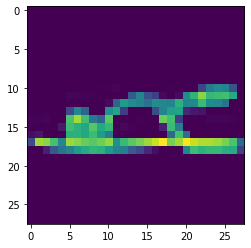

With label: tensor(5)


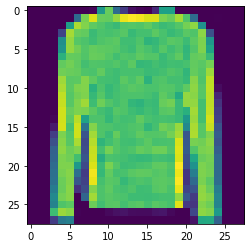

With label: tensor(2)


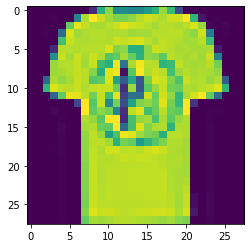

With label: tensor(0)


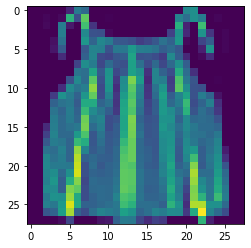

With label: tensor(6)


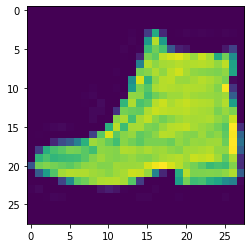

With label: tensor(9)


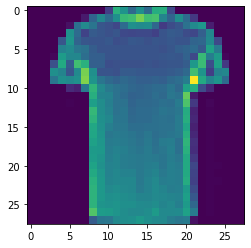

With label: tensor(0)


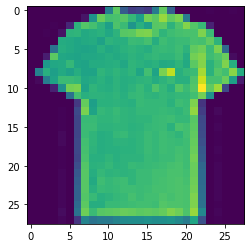

With label: tensor(0)


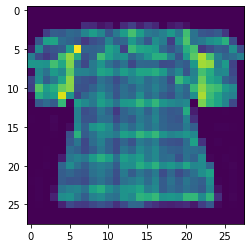

With label: tensor(6)


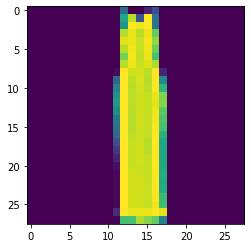

With label: tensor(3)


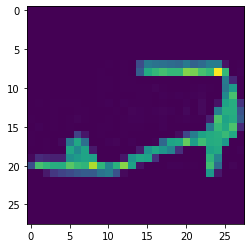

With label: tensor(5)


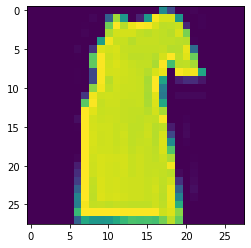

With label: tensor(3)


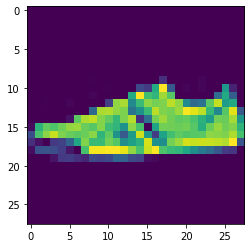

With label: tensor(7)


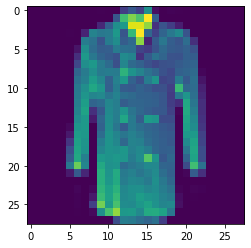

With label: tensor(4)


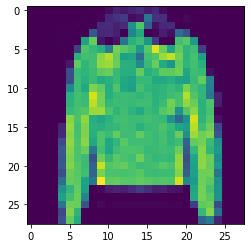

With label: tensor(4)


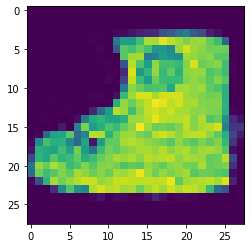

With label: tensor(9)


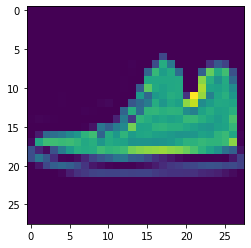

With label: tensor(7)


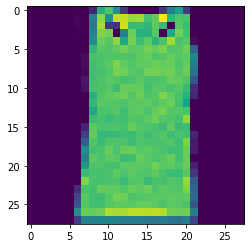

With label: tensor(0)


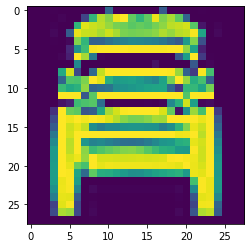

With label: tensor(2)


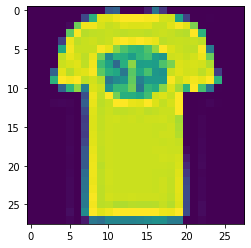

With label: tensor(0)


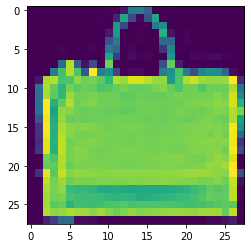

With label: tensor(8)


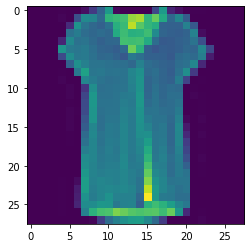

With label: tensor(6)


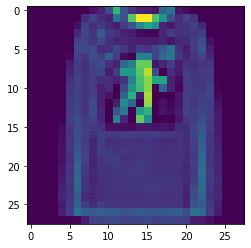

With label: tensor(2)


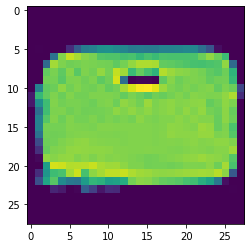

With label: tensor(8)


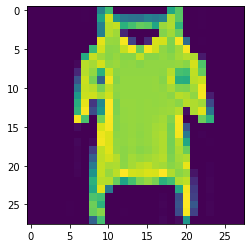

With label: tensor(6)


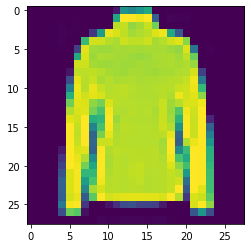

With label: tensor(4)


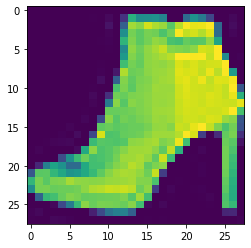

With label: tensor(9)


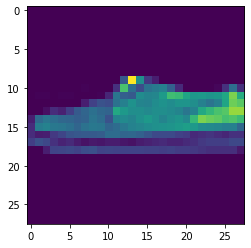

With label: tensor(7)


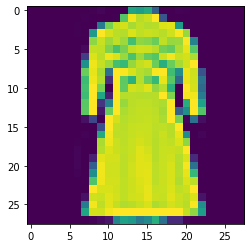

With label: tensor(3)


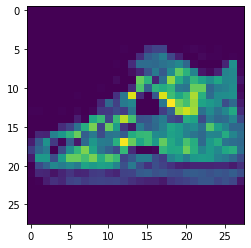

With label: tensor(5)


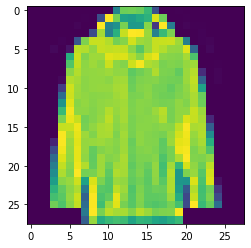

With label: tensor(4)


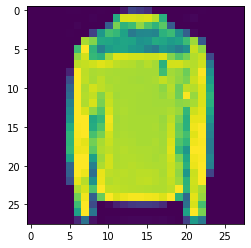

With label: tensor(2)


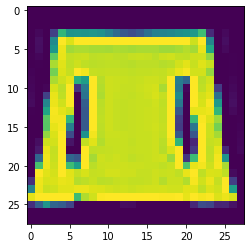

With label: tensor(0)


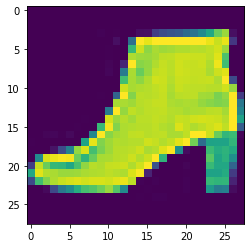

With label: tensor(9)


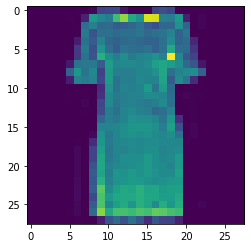

With label: tensor(3)


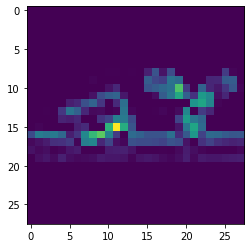

With label: tensor(5)


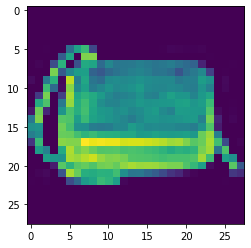

With label: tensor(8)


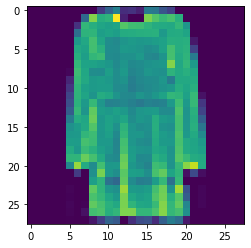

With label: tensor(3)


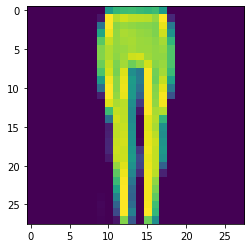

With label: tensor(1)


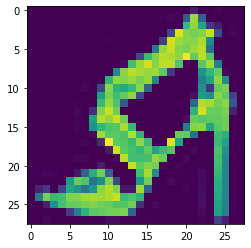

With label: tensor(5)


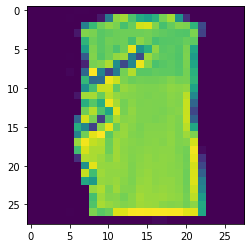

With label: tensor(0)


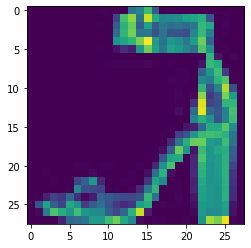

With label: tensor(5)


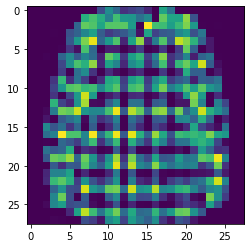

With label: tensor(6)


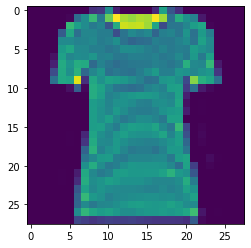

With label: tensor(0)


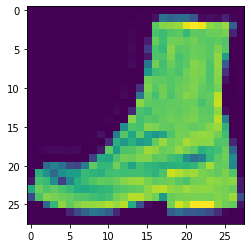

With label: tensor(9)


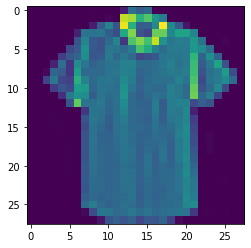

With label: tensor(6)


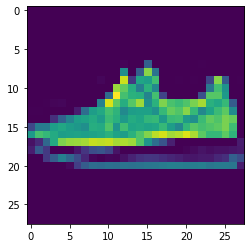

With label: tensor(7)


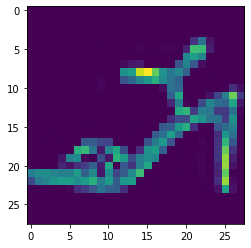

With label: tensor(5)


In [19]:
print('Iterating the dataloader')
e = iter(train_loader)
print('Gives us a list of length', len(e))
print('Which is the number of batches of data')
e.next()
samples = e.next()
print('By taking one batch, we get a list of:', len(samples))
print('with two tensors: 0th', samples[0].shape, '1st', samples[1].shape)
for i, c in enumerate(samples[0]):
    plt.imshow(torch.squeeze(c))
    plt.show()
    print('With label:', samples[1][i])


In [20]:
npixels = 28
input_size = (npixels)**2 
hidden = 256
num_classes =10
epochs = 10
lr = 10e-3

# If you want to use a GPU 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleFeedForward(input_size, hidden, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [21]:
#steps = len(train_loader)

ff_loss_history = []
ff_acc_history = []

for epoch in range(epochs):
    
    total_loss = 0
    
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        
        #For accuracy
        n_correct = 0
        n_samples = 0 
        
        images = images.to(device) #(B, C, H, W)  
        labels = labels.to(device)
        
        #convert images grey for FF network
        images = torch.mean(images, dim=1) # (B, H, W)
        images = images.reshape(-1, input_size) #(B, H*W)
        
        # here you predict
        y_pred = model(images)
        loss = criterion(y_pred, 
                         labels)
        total_loss += loss
        
        _, predictions = torch.max(y_pred, 1)
            
        #For accuracy
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
        
        # Zeros the gradients
        optimizer.zero_grad()
        # Calculate the gradients
        loss.backward()
        #Update the weights
        optimizer.step()
        
    acc = 100.0 * n_correct / n_samples    
    ff_loss_history.append(total_loss/i)
    ff_acc_history.append(acc)
    print(f'epoch:{epoch:.0f}|loss:{ff_loss_history[-1]:.2f}|accuracy = {acc:.2f}')
    
    

   

epoch:0|loss:0.51|accuracy = 87.50
epoch:1|loss:0.39|accuracy = 84.38
epoch:2|loss:0.36|accuracy = 89.84
epoch:3|loss:0.35|accuracy = 85.94
epoch:4|loss:0.33|accuracy = 86.72
epoch:5|loss:0.32|accuracy = 92.97
epoch:6|loss:0.32|accuracy = 84.38
epoch:7|loss:0.31|accuracy = 90.62
epoch:8|loss:0.30|accuracy = 91.41
epoch:9|loss:0.30|accuracy = 89.84


In [22]:
class SimpleConv(nn.Module):
    def __init__(self):
        super(SimpleConv, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 2)        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*13*13, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x))) # (B, C, H, W)
        #print(x.shape)
        x = x.view(-1, 16*13*13) # (B, C*H*W)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        
        return x
    

In [23]:
model = SimpleConv().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 10

In [24]:
conv_loss_history = []
conv_acc_history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        n_correct = 0
        n_samples = 0 
        
        images = images.to(device) #(B, C, H, W)
        labels = labels.to(device)
        
        y_pred = model(images)
        loss = criterion(y_pred, labels)
        total_loss += loss
        
        _, predictions = torch.max(y_pred, 1)
            
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    acc = 100.0 * n_correct / n_samples    
    conv_loss_history.append(total_loss/i)
    conv_acc_history.append(acc)
    print(f'epoch:{epoch:.0f}|loss:{conv_loss_history[-1]:.2f}|accuracy = {acc:.2f}')
        

epoch:0|loss:0.42|accuracy = 92.97
epoch:1|loss:0.28|accuracy = 89.84
epoch:2|loss:0.24|accuracy = 89.84
epoch:3|loss:0.21|accuracy = 95.31
epoch:4|loss:0.19|accuracy = 90.62
epoch:5|loss:0.17|accuracy = 98.44
epoch:6|loss:0.16|accuracy = 95.31
epoch:7|loss:0.15|accuracy = 93.75
epoch:8|loss:0.13|accuracy = 96.09
epoch:9|loss:0.13|accuracy = 95.31


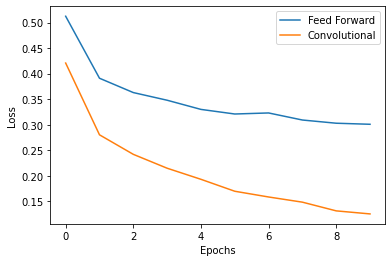

In [25]:
plt.plot(np.arange(epochs), ff_loss_history, label='Feed Forward')
plt.plot(np.arange(epochs), conv_loss_history, label='Convolutional')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

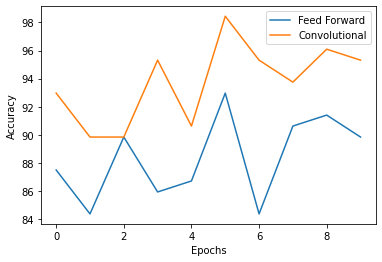

In [26]:
plt.plot(np.arange(epochs), ff_acc_history, label='Feed Forward')
plt.plot(np.arange(epochs), conv_acc_history, label='Convolutional')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# c)

# Now let's see how a validation set can be used to monitor the overfitting of a model during training. We will stick to the convolutional network

In [27]:
train_set, val_set = torch.utils.data.random_split(
    train_set,
    [int(len(train_set)*0.8), int(len(train_set)*0.2)]
)

In [28]:
train_loader = torch.utils.data.DataLoader(
            train_set,
            batch_size=128,
            shuffle=True,
            drop_last = True,
        ) 

val_loader = torch.utils.data.DataLoader(
            val_set,
            batch_size=128,
            shuffle=True,
            drop_last = True,
        ) 

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleConv().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [30]:

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []


for epoch in range(epochs):
    model.train()
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        train_correct = 0
        train_samples = 0 

        
        images = images.to(device) #(B, C, H, W)
        labels = labels.to(device)
        
        y_pred = model(images)
        train_loss = criterion(y_pred, labels)
        total_loss += train_loss
        
        _, predictions = torch.max(y_pred, 1)
            
        train_samples += labels.shape[0]
        train_correct += (predictions == labels).sum().item()
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    
    train_acc = 100.0 * train_correct / train_samples
    train_loss_history.append(total_loss/i)
    train_acc_history.append(train_acc)    

    # Now do the validation
    model.eval()
    total_loss=0
    with torch.no_grad():
        val_correct = 0
        val_samples = 0 
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device) #(B, C, H, W)
            labels = labels.to(device)
            
            y_pred = model(images)
            val_loss = criterion(y_pred, labels)
            total_loss += val_loss
            _, predictions = torch.max(y_pred, 1)
            
            val_samples += labels.shape[0]
            val_correct += (predictions == labels).sum().item()
        val_acc = 100.0 * val_correct / val_samples
        val_acc_history.append(val_acc)
        val_loss_history.append(total_loss/i)
        
        print(f'Epoch= {epoch:.0f}')
        print(f'|Training|Loss:{train_loss_history[-1]:.2f}|Acc:{train_acc:.2f}|')
        print(f'|Validation|Loss:{val_loss_history[-1]:.2f}|Acc:{val_acc:.2f}|')

del model

Epoch= 0
|Training|Loss:0.54|Acc:89.84|
|Validation|Loss:0.34|Acc:88.10|
Epoch= 1
|Training|Loss:0.33|Acc:88.28|
|Validation|Loss:0.31|Acc:88.81|
Epoch= 2
|Training|Loss:0.29|Acc:93.75|
|Validation|Loss:0.31|Acc:88.93|
Epoch= 3
|Training|Loss:0.26|Acc:84.38|
|Validation|Loss:0.30|Acc:89.38|
Epoch= 4
|Training|Loss:0.24|Acc:91.41|
|Validation|Loss:0.29|Acc:89.78|
Epoch= 5
|Training|Loss:0.22|Acc:93.75|
|Validation|Loss:0.29|Acc:89.87|
Epoch= 6
|Training|Loss:0.21|Acc:87.50|
|Validation|Loss:0.31|Acc:89.52|
Epoch= 7
|Training|Loss:0.20|Acc:88.28|
|Validation|Loss:0.29|Acc:90.10|
Epoch= 8
|Training|Loss:0.19|Acc:90.62|
|Validation|Loss:0.33|Acc:89.36|
Epoch= 9
|Training|Loss:0.18|Acc:93.75|
|Validation|Loss:0.31|Acc:89.85|


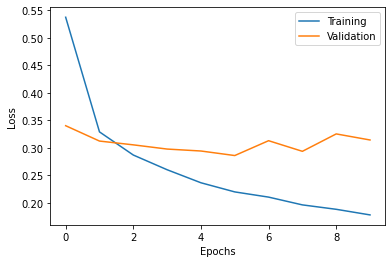

In [34]:
plt.plot(np.arange(epochs), train_loss_history, label='Training')
plt.plot(np.arange(epochs), val_loss_history, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

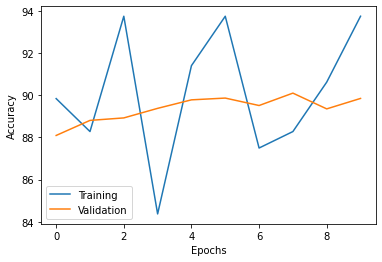

In [35]:
plt.plot(np.arange(epochs), train_acc_history, label='Training')
plt.plot(np.arange(epochs), val_acc_history, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Now let's modify the existing convolutional network adding some regularization. 
Dropout, batch norm, weight initialization, L2 regulatization 

In [36]:
class AdvanceConv(nn.Module):
    def __init__(self):
        super(AdvanceConv, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 3, 2)
        self.fc1 = nn.Linear(16*13*13, 128)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(128, num_classes)
        
        self.dropout = nn.Dropout(0.5)
        self.bn =nn.BatchNorm1d(128)       
        
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0.1)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    
    def forward(self, x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = x.view(-1, 16*13*13)
        #print(x.shape)
        x = F.relu((self.fc1(x)))
        x = self.dropout(x)
        #print(x.shape)
        x = self.fc3(x)
        #print(x.shape)
        
        return x
        
    
        
    




In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AdvanceConv().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=10e-3)

In [39]:
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []


epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
    
        train_correct = 0
        train_samples = 0 
    
        images = images.to(device) #(B, C, H, W)
        labels = labels.to(device)
        
        y_pred = model(images)
        train_loss = criterion(y_pred, labels)
        total_loss += train_loss
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        _, predictions = torch.max(y_pred, 1)
            
        train_samples += labels.shape[0]
        train_correct += (predictions == labels).sum().item()
        
    
    train_acc = 100.0 * train_correct / train_samples
    train_loss_history.append(total_loss/i)
    train_acc_history.append(train_acc)    
    
    total_loss =0
    with torch.no_grad():
        val_correct = 0
        val_samples = 0 
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device) #(B, C, H, W)
            labels = labels.to(device)
            
            y_pred = model(images)
            val_loss = criterion(y_pred, labels)
            total_loss += val_loss
            _, predictions = torch.max(y_pred, 1)
            
            val_samples += labels.shape[0]
            val_correct += (predictions == labels).sum().item()
        
        val_acc = 100.0 * val_correct / val_samples
        val_acc_history.append(val_acc)
        val_loss_history.append(total_loss/i)
        
    print(f'Epoch= {epoch:.0f}')
    print(f'|Training|Loss:{train_loss_history[-1]:.2f}|Acc:{train_acc:.2f}|')
    print(f'|Validation|Loss:{val_loss_history[-1]:.2f}|Acc:{val_acc:.2f}|')
                         
torch.save(model.state_dict(), 'best_model.pt')           
del model

Epoch= 1
|Training|Loss:0.63|Acc:82.03|
|Validation|Loss:0.60|Acc:78.50|
Epoch= 2
|Training|Loss:0.60|Acc:75.78|
|Validation|Loss:0.61|Acc:78.45|
Epoch= 3
|Training|Loss:0.58|Acc:78.12|
|Validation|Loss:0.56|Acc:80.07|
Epoch= 4
|Training|Loss:0.57|Acc:80.47|
|Validation|Loss:0.55|Acc:80.67|
Epoch= 5
|Training|Loss:0.56|Acc:85.16|
|Validation|Loss:0.55|Acc:80.70|
Epoch= 6
|Training|Loss:0.56|Acc:83.59|
|Validation|Loss:0.56|Acc:79.95|
Epoch= 7
|Training|Loss:0.55|Acc:76.56|
|Validation|Loss:0.53|Acc:82.12|
Epoch= 8
|Training|Loss:0.55|Acc:82.81|
|Validation|Loss:0.54|Acc:81.11|
Epoch= 9
|Training|Loss:0.54|Acc:85.94|
|Validation|Loss:0.55|Acc:81.05|


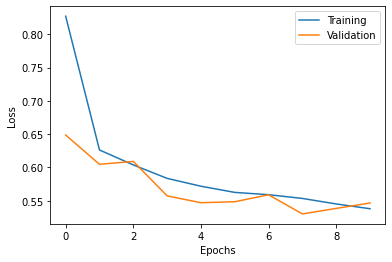

In [41]:
plt.plot(np.arange(epochs), train_loss_history, label='Training')
plt.plot(np.arange(epochs), val_loss_history, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

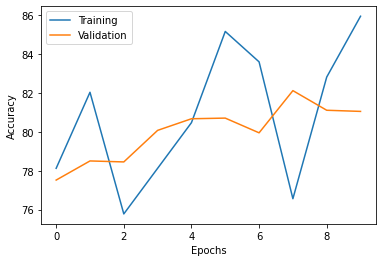

In [42]:
plt.plot(np.arange(epochs), train_acc_history, label='Training')
plt.plot(np.arange(epochs), val_acc_history, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Inference

In [43]:
model = AdvanceConv().to(device)
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

AdvanceConv(
  (conv1): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 3, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=2704, out_features=128, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [44]:
#test_set = dataset(test_file['test_set_x'][:], test_file['test_set_y'][:])

test_loader = torch.utils.data.DataLoader(
            test_set,
            batch_size=1,
            shuffle=False,
            drop_last = False,
        ) 

In [45]:
with torch.no_grad():
    test_correct = 0
    test_samples = 0 
    total_loss = 0
    for i, (images, labels) in enumerate(test_loader):
        
        images = images.to(device) #(B, C, H, W)
        labels = labels.to(device)

        y_pred = model(images)
        test_loss = criterion(y_pred, labels)
        total_loss += test_loss
        _, predictions = torch.max(y_pred, 1)

        test_samples += labels.shape[0]
        test_correct += (predictions == labels).sum().item()
    
    test_acc = 100.0 * val_correct / val_samples
    print(i)
    total_loss = total_loss/i

    print('Inference')
    print(f'|Testing|Loss:{total_loss:.2f}|Acc:{test_acc:.2f}|')
    

9999
Inference
|Testing|Loss:0.48|Acc:81.05|
